* We want to see if the the fitted models (to real data) from popular topic modeling / NMF algorithms satisfy anchor word assumptions

* I use the datasets from [fastTopics-experiments](https://stephenslab.github.io/fastTopics-experiments/) and [SLA](https://zihao12.github.io/ebpmf_data_analysis/data_preprocessing_sla) . I look at fits using different number of topics. I examine SLA, NIPS and droplet dataset more closely. 

* I define word $j$ a **anchor word** for topic $k$ if $f_{jk} > 100 \sum_{l \neq k} f_{jl}$. Here $F, L$ are transformed into multinomial model so $\sum_j f_{jk} = 1$ (there is a concern that if a word only appears in one document, then it's very easy to be anchor word... ; if i also require anchor word to be expressed more than $10/p$ then there are far fewer anchor words in droplet and pbmc_68k data)

In [1]:
import os
import sys
import pickle
import argparse
from scipy import sparse
import numpy as np
import rpy2.robjects as robjects

script_dir = "../"
sys.path.append(os.path.abspath(script_dir))
from file2 import *
from factorize import *
from smallsim_functions import simulate_multinomial_counts
from misc import *

np.random.seed(123)

## SLA

In [2]:
datafile="../../ebpmf_data_analysis/output/fastTopics_fit/fit_sla_fastTopics_k6.Rds"
vocabfile="../../ebpmf_data_analysis/data/SLA/vocab.sla.txt"
titlefile="../../ebpmf_data_analysis/data/SLA/title.sla.txt"

readRDS = robjects.r['readRDS']
data = readRDS(datafile)
F = np.asarray(data.rx2('F'))
L = np.asarray(data.rx2('L'))
s = np.asarray(data.rx2('s'))
del data

for i in range(F.shape[1]):
    n_anchor = find_anchor_word_k2(F, i).sum()
    print(f"topic {i}: {n_anchor} anchor words")

vocab = np.loadtxt(vocabfile, delimiter="\n", dtype = "str")
title = np.loadtxt(titlefile, delimiter="\n", dtype = "str")

topic 0: 566 anchor words
topic 1: 429 anchor words
topic 2: 288 anchor words
topic 3: 470 anchor words
topic 4: 840 anchor words
topic 5: 804 anchor words


In [3]:
p, k = F.shape
n, _ = L.shape

C = F @ L.T
C = C @ C.T / n
Cbar = C / C.sum(axis = 1)[:, None]

In [4]:
%%capture
S0, B0, A0, _, _, _, _, _ = factorizeC(C, K=k, rectifier='no', optimizer='activeSet')
Cbar = pca_proj(Cbar)

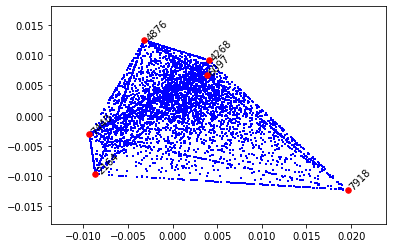

[(4876, 'misspecification'),
 (7918, 'test'),
 (6097, 'priors'),
 (2164, 'disease'),
 (4268, 'lasso'),
 (7440, 'spatial')]

In [5]:
which_dim = [0, 1]
vis_extremal_pca(Cbar, S0, which_dim = which_dim, annotate=True,fontsize=10)
[(w, vocab[w]) for w in S0]

### Look at all the anchor words

I have checked all anchor words are very close to the selected anchor words by our algorithm

## Check the meaning of the topics & anchor words

In [6]:
tpx_idx = match_topics(F, B0).astype(int)
for i in range(k):
    print(f"############ topic {i} #############")
    print("top words")
    print(vocab[S0[tpx_idx[i]]])
    idx = np.argsort(F[:, i])[-10:]
    print(vocab[idx])
    idx = np.argsort(L[:, i])[-10:]
    print("top L[:, k]")
    print(L[idx,i])
    print("top samples' titles")
    print(title[idx])

############ topic 0 #############
top words
priors
['posterior' 'random' 'process' 'bayesian' 'prior' 'density' 'model'
 'distributions' 'distribution' 'models']
top L[:, k]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
top samples' titles
['Evaluation of formal posterior distributions via {M}arkov chain arguments'
 'On identification of multi-factor models with correlated residuals'
 'Consistency of {M}arkov chain quasi-{M}onte {C}arlo on continuous state spaces'
 'Efficient recursions for general factorisable models'
 'A {M}onte {C}arlo method for computing the marginal likelihood in nondecomposable {G}aussian graphical models'
 'Saddlepoint approximation for moment generating functions of truncated random variables'
 'Enriched conjugate and reference priors for the {W}ishart family on symmetric cones'
 'Identifiability of parameters in latent structure models with many observed variables'
 "Geometric ergodicity of van {D}yk and {M}eng's algorithm for the multivariate {S}tudent's {$t$} model"
 'W

## NIPS

### k = 4

topic 0: 655 anchor words
topic 1: 407 anchor words
topic 2: 507 anchor words
topic 3: 398 anchor words
[inference.findS] Start finding the set of anchor bases S...
+ Finish finding set S!
  - Discovered 4 basis vectors by [sparsePartial] method.
  - Elapsed time = 9.0638 seconds

F[anchor_words,:]
[[0.       0.       0.       0.000495]
 [0.       0.006829 0.       0.      ]
 [0.000428 0.       0.       0.      ]
 [0.       0.       0.000203 0.      ]]


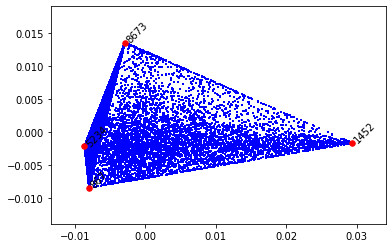

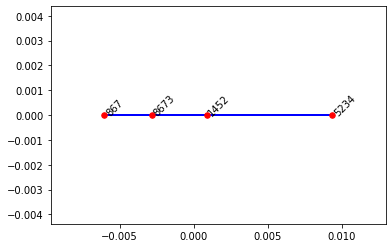

In [7]:
dataname="nips"
datadir=f"../../../gdrive/github_data/fastTopics-experiments-data/output/{dataname}/rds"
modelname=f"fit-{dataname}-scd-ex-k=4.rds"

readRDS = robjects.r['readRDS']
data = readRDS(f"{datadir}/{modelname}")
fit = data.rx2('fit')

L = np.asarray(fit.rx2('L'))
F = np.asarray(fit.rx2('F'))
F, L = poisson2multinom(F, L)

for i in range(F.shape[1]):
    n_anchor = find_anchor_word_k2(F, i).sum()
    print(f"topic {i}: {n_anchor} anchor words")

n, k = L.shape
p, _ = F.shape

C = L @ F.T
C = (C.T @ C) / n

Cbar = C / C.sum(axis = 1)[:, None]

S0, _, _ = findS(Cbar, k)
print("F[anchor_words,:]")
print(F[S0,:].round(6))

Cbar = pca_proj(Cbar)
vis_extremal_pca(Cbar, S0, which_dim = [0, 1], annotate=True,fontsize=10)
vis_extremal_pca(Cbar, S0, which_dim = [2, 3], annotate=True,fontsize=10)

### k=6

topic 0: 45 anchor words
topic 1: 158 anchor words
topic 2: 529 anchor words
topic 3: 63 anchor words
topic 4: 278 anchor words
topic 5: 237 anchor words
[inference.findS] Start finding the set of anchor bases S...
+ Finish finding set S!
  - Discovered 6 basis vectors by [sparsePartial] method.
  - Elapsed time = 6.4412 seconds

F[anchor_words,:]
[[0.       0.000297 0.       0.       0.       0.      ]
 [0.       0.       0.       0.000164 0.       0.      ]
 [0.       0.       0.0005   0.       0.       0.      ]
 [0.000222 0.       0.       0.       0.       0.      ]
 [0.       0.       0.       0.       0.000331 0.      ]
 [0.       0.       0.       0.       0.       0.000465]]


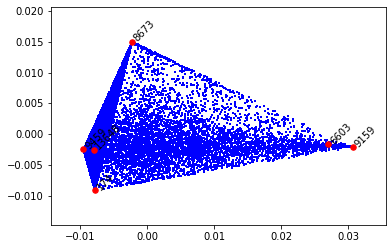

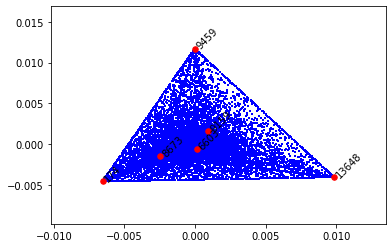

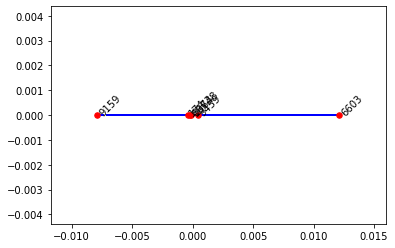

In [8]:
dataname="nips"
datadir=f"../../../gdrive/github_data/fastTopics-experiments-data/output/{dataname}/rds"
modelname=f"fit-{dataname}-scd-ex-k=6.rds"

readRDS = robjects.r['readRDS']
data = readRDS(f"{datadir}/{modelname}")
fit = data.rx2('fit')

L = np.asarray(fit.rx2('L'))
F = np.asarray(fit.rx2('F'))
F, L = poisson2multinom(F, L)

for i in range(F.shape[1]):
    n_anchor = find_anchor_word_k2(F, i).sum()
    print(f"topic {i}: {n_anchor} anchor words")

n, k = L.shape
p, _ = F.shape

C = L @ F.T
C = (C.T @ C) / n

Cbar = C / C.sum(axis = 1)[:, None]

S0, _, _ = findS(Cbar, k)
print("F[anchor_words,:]")
print(F[S0,:].round(6))

Cbar = pca_proj(Cbar)
vis_extremal_pca(Cbar, S0, which_dim = [0, 1], annotate=True,fontsize=10)
vis_extremal_pca(Cbar, S0, which_dim = [2, 3], annotate=True,fontsize=10)
vis_extremal_pca(Cbar, S0, which_dim = [4, 5], annotate=True,fontsize=10)

### k=10

topic 0: 14 anchor words
topic 1: 5 anchor words
topic 2: 344 anchor words
topic 3: 67 anchor words
topic 4: 14 anchor words
topic 5: 156 anchor words
topic 6: 94 anchor words
topic 7: 115 anchor words
topic 8: 86 anchor words
topic 9: 11 anchor words
[inference.findS] Start finding the set of anchor bases S...
+ Finish finding set S!
  - Discovered 10 basis vectors by [sparsePartial] method.
  - Elapsed time = 14.6860 seconds

F[anchor_words,:]
[[0.     0.     0.     0.     0.     0.     0.     0.     0.0003 0.    ]
 [0.     0.     0.     0.     0.0001 0.     0.     0.     0.     0.    ]
 [0.0001 0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.0006 0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.0007 0.     0.     0.     0.     0.     0.     0.    ]
 [0.     0.0003 0.     0.     0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.0004 0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.

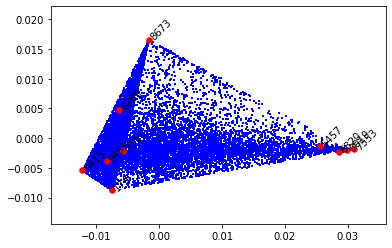

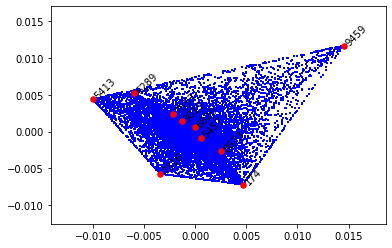

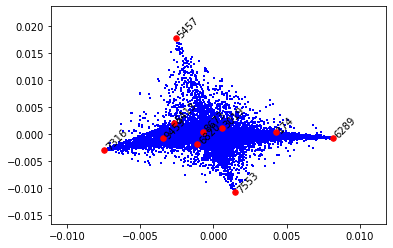

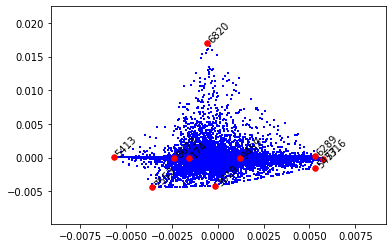

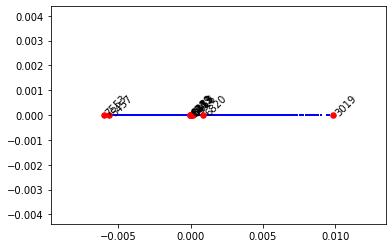

In [9]:
dataname="nips"
datadir=f"../../../gdrive/github_data/fastTopics-experiments-data/output/{dataname}/rds"
modelname=f"fit-{dataname}-scd-ex-k=10.rds"

readRDS = robjects.r['readRDS']
data = readRDS(f"{datadir}/{modelname}")
fit = data.rx2('fit')

L = np.asarray(fit.rx2('L'))
F = np.asarray(fit.rx2('F'))
F, L = poisson2multinom(F, L)

for i in range(F.shape[1]):
    n_anchor = find_anchor_word_k2(F, i).sum()
    print(f"topic {i}: {n_anchor} anchor words")

n, k = L.shape
p, _ = F.shape

C = L @ F.T
C = (C.T @ C) / n

Cbar = C / C.sum(axis = 1)[:, None]

S0, _, _ = findS(Cbar, k)
print("F[anchor_words,:]")
print(F[S0,:].round(4))

Cbar = pca_proj(Cbar)
vis_extremal_pca(Cbar, S0, which_dim = [0, 1], annotate=True,fontsize=10)
vis_extremal_pca(Cbar, S0, which_dim = [2, 3], annotate=True,fontsize=10)
vis_extremal_pca(Cbar, S0, which_dim = [4, 5], annotate=True,fontsize=10)
vis_extremal_pca(Cbar, S0, which_dim = [6, 7], annotate=True,fontsize=10)
vis_extremal_pca(Cbar, S0, which_dim = [8, 9], annotate=True,fontsize=10)

## newsgroups

### k = 4

In [10]:
dataname="newsgroups"
datadir=f"../../../gdrive/github_data/fastTopics-experiments-data/output/{dataname}/rds"
modelname=f"fit-{dataname}-scd-ex-k=4.rds"

readRDS = robjects.r['readRDS']
data = readRDS(f"{datadir}/{modelname}")
fit = data.rx2('fit')

L = np.asarray(fit.rx2('L'))
F = np.asarray(fit.rx2('F'))
del data, fit

F, L = poisson2multinom(F, L)

for i in range(F.shape[1]):
    n_anchor = find_anchor_word_k2(F, i).sum()
    print(f"topic {i}: {n_anchor} anchor words")
    

topic 0: 8147 anchor words
topic 1: 6654 anchor words
topic 2: 5741 anchor words
topic 3: 8373 anchor words


### k = 8

In [11]:
dataname="newsgroups"
datadir=f"../../../gdrive/github_data/fastTopics-experiments-data/output/{dataname}/rds"
modelname=f"fit-{dataname}-scd-ex-k=8.rds"

readRDS = robjects.r['readRDS']
data = readRDS(f"{datadir}/{modelname}")
fit = data.rx2('fit')

L = np.asarray(fit.rx2('L'))
F = np.asarray(fit.rx2('F'))
del data, fit

F, L = poisson2multinom(F, L)

for i in range(F.shape[1]):
    n_anchor = find_anchor_word_k2(F, i).sum()
    print(f"topic {i}: {n_anchor} anchor words")
    

topic 0: 3457 anchor words
topic 1: 3280 anchor words
topic 2: 2221 anchor words
topic 3: 2627 anchor words
topic 4: 2790 anchor words
topic 5: 3293 anchor words
topic 6: 2839 anchor words
topic 7: 3694 anchor words


### k = 12

In [12]:
dataname="newsgroups"
datadir=f"../../../gdrive/github_data/fastTopics-experiments-data/output/{dataname}/rds"
modelname=f"fit-{dataname}-scd-ex-k=12.rds"

readRDS = robjects.r['readRDS']
data = readRDS(f"{datadir}/{modelname}")
fit = data.rx2('fit')

L = np.asarray(fit.rx2('L'))
F = np.asarray(fit.rx2('F'))
del data, fit

F, L = poisson2multinom(F, L)

for i in range(F.shape[1]):
    n_anchor = find_anchor_word_k2(F, i).sum()
    print(f"topic {i}: {n_anchor} anchor words")
    

topic 0: 2309 anchor words
topic 1: 1034 anchor words
topic 2: 2745 anchor words
topic 3: 14 anchor words
topic 4: 2380 anchor words
topic 5: 1924 anchor words
topic 6: 1683 anchor words
topic 7: 1455 anchor words
topic 8: 2022 anchor words
topic 9: 2601 anchor words
topic 10: 2396 anchor words
topic 11: 2385 anchor words


## pbmc68

### k = 4

In [13]:
dataname="pbmc68k"
datadir=f"../../../gdrive/github_data/fastTopics-experiments-data/output/{dataname}/rds"
modelname=f"fit-{dataname}-scd-ex-k=4.rds"

readRDS = robjects.r['readRDS']
data = readRDS(f"{datadir}/{modelname}")
fit = data.rx2('fit')

L = np.asarray(fit.rx2('L'))
F = np.asarray(fit.rx2('F'))
del data, fit

F, L = poisson2multinom(F, L)

for i in range(F.shape[1]):
    n_anchor = find_anchor_word_k2(F, i).sum()
    print(f"topic {i}: {n_anchor} anchor words")
    

topic 0: 834 anchor words
topic 1: 1093 anchor words
topic 2: 545 anchor words
topic 3: 1242 anchor words


### k = 8

In [14]:
dataname="pbmc68k"
datadir=f"../../../gdrive/github_data/fastTopics-experiments-data/output/{dataname}/rds"
modelname=f"fit-{dataname}-scd-ex-k=8.rds"

readRDS = robjects.r['readRDS']
data = readRDS(f"{datadir}/{modelname}")
fit = data.rx2('fit')

L = np.asarray(fit.rx2('L'))
F = np.asarray(fit.rx2('F'))
del data, fit

F, L = poisson2multinom(F, L)

for i in range(F.shape[1]):
    n_anchor = find_anchor_word_k2(F, i).sum()
    print(f"topic {i}: {n_anchor} anchor words")
    

topic 0: 372 anchor words
topic 1: 417 anchor words
topic 2: 430 anchor words
topic 3: 337 anchor words
topic 4: 272 anchor words
topic 5: 688 anchor words
topic 6: 155 anchor words
topic 7: 426 anchor words


### k = 12

In [15]:
dataname="pbmc68k"
datadir=f"../../../gdrive/github_data/fastTopics-experiments-data/output/{dataname}/rds"
modelname=f"fit-{dataname}-scd-ex-k=12.rds"

readRDS = robjects.r['readRDS']
data = readRDS(f"{datadir}/{modelname}")
fit = data.rx2('fit')

L = np.asarray(fit.rx2('L'))
F = np.asarray(fit.rx2('F'))
del data, fit

F, L = poisson2multinom(F, L)

for i in range(F.shape[1]):
    n_anchor = find_anchor_word_k2(F, i).sum()
    print(f"topic {i}: {n_anchor} anchor words")
    

topic 0: 295 anchor words
topic 1: 147 anchor words
topic 2: 365 anchor words
topic 3: 68 anchor words
topic 4: 553 anchor words
topic 5: 37 anchor words
topic 6: 194 anchor words
topic 7: 392 anchor words
topic 8: 138 anchor words
topic 9: 250 anchor words
topic 10: 270 anchor words
topic 11: 141 anchor words


## droplet

### k = 4

In [16]:
%%capture
dataname="droplet"
datadir=f"../../../gdrive/github_data/fastTopics-experiments-data/output/{dataname}/rds"
modelname=f"fit-{dataname}-scd-ex-k=4.rds"

readRDS = robjects.r['readRDS']
data = readRDS(f"{datadir}/{modelname}")
fit = data.rx2('fit')

L = np.asarray(fit.rx2('L'))
F = np.asarray(fit.rx2('F'))
del data, fit

F, L = poisson2multinom(F, L)


    
k = F.shape[1]
C = F @ L.T
Cbar = C / C.sum(axis = 1)[:, None]

S0, _, _ = findS(Cbar, k)

F[anchor_words,:]
[[0.000e+00 0.000e+00 4.000e-06 0.000e+00]
 [1.132e-03 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 9.000e-06 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 1.220e-04]]
topic 0: 231 anchor words
topic 1: 330 anchor words
topic 2: 201 anchor words
topic 3: 2067 anchor words


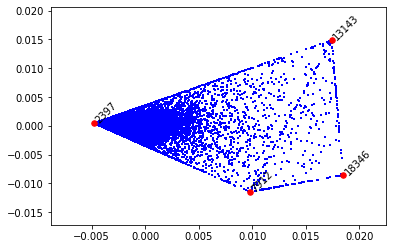

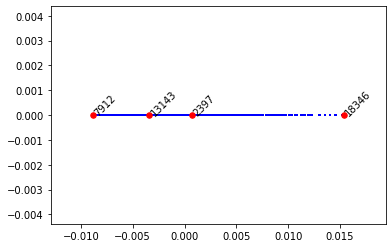

In [17]:
print("F[anchor_words,:]")
print(F[S0,:].round(6))
for i in range(F.shape[1]):
    n_anchor = find_anchor_word_k2(F, i).sum()
    print(f"topic {i}: {n_anchor} anchor words")

Cbar = pca_proj(Cbar)
vis_extremal_pca(Cbar, S0, which_dim = [0, 1], annotate=True,fontsize=10)
vis_extremal_pca(Cbar, S0, which_dim = [2, 3], annotate=True,fontsize=10)

### look at the true anchor words

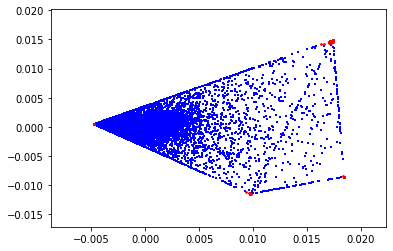

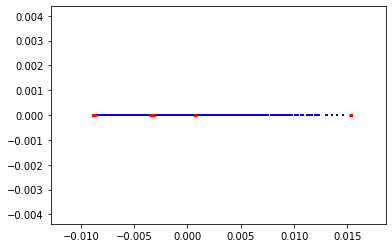

In [18]:
all_anchor_word = []
for i in range(k):
    ind = np.where(find_anchor_word_k2(F, i) == True)[0].tolist()
    all_anchor_word += ind
# print(set(S0).intersection(set(all_anchor_word)))

vis_extremal_pca(Cbar, all_anchor_word, which_dim = [0, 1], annotate=False,fontsize=10, s = 3)
vis_extremal_pca(Cbar, all_anchor_word, which_dim = [2, 3], annotate=False,fontsize=10, s= 3)

### k = 8

In [19]:
%%capture
dataname="droplet"
datadir=f"../../../gdrive/github_data/fastTopics-experiments-data/output/{dataname}/rds"
modelname=f"fit-{dataname}-scd-ex-k=8.rds"

readRDS = robjects.r['readRDS']
data = readRDS(f"{datadir}/{modelname}")
fit = data.rx2('fit')

L = np.asarray(fit.rx2('L'))
F = np.asarray(fit.rx2('F'))
del data, fit

F, L = poisson2multinom(F, L)


    
k = F.shape[1]
C = F @ L.T
Cbar = C / C.sum(axis = 1)[:, None]

S0, _, _ = findS(Cbar, k)


F[anchor_words,:]
[[0.0000e+00 0.0000e+00 1.7518e-01 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  1.3710e-03 0.0000e+00]
 [0.0000e+00 2.0000e-06 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00]
 [8.1000e-05 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00]
 [0.0000e+00 0.0000e+00 0.0000e+00 1.0000e-06 0.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 3.0000e-06 0.0000e+00
  0.0000e+00 0.0000e+00]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 1.0000e-06
  0.0000e+00 0.0000e+00]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 1.5000e-05]]
topic 0: 169 anchor words
topic 1: 159 anchor words
topic 2: 51 anchor words
topic 3: 140 anchor words
topic 4: 249 anchor words
topic 5: 139 anchor words
topic 6: 779 anchor words
topic 7: 573 anchor words


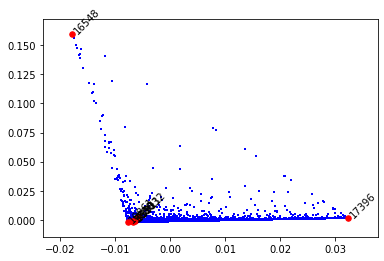

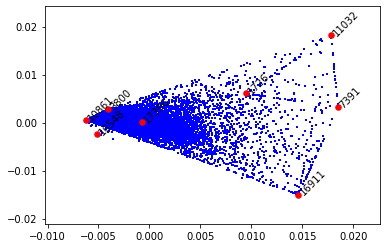

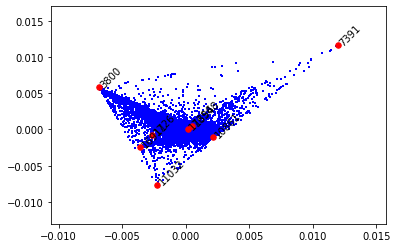

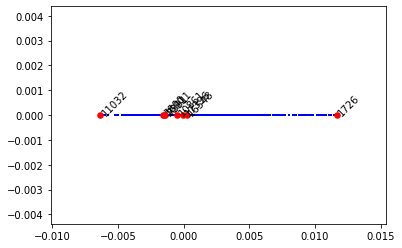

In [20]:
print("F[anchor_words,:]")
print(F[S0,:].round(6))
for i in range(F.shape[1]):
    n_anchor = find_anchor_word_k2(F, i).sum()
    print(f"topic {i}: {n_anchor} anchor words")

Cbar = pca_proj(Cbar)
vis_extremal_pca(Cbar, S0, which_dim = [0, 1], annotate=True,fontsize=10)
vis_extremal_pca(Cbar, S0, which_dim = [2, 3], annotate=True,fontsize=10)
vis_extremal_pca(Cbar, S0, which_dim = [4, 5], annotate=True,fontsize=10)
vis_extremal_pca(Cbar, S0, which_dim = [6, 7], annotate=True,fontsize=10)

### where true anchor words lie?

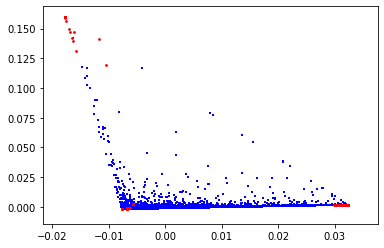

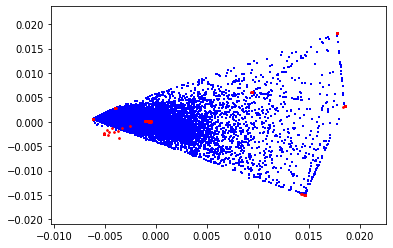

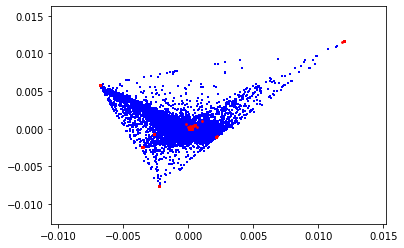

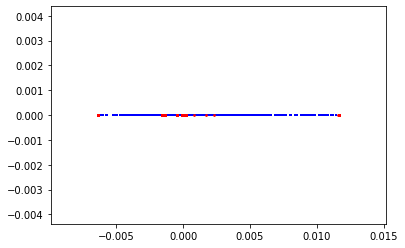

In [21]:
all_anchor_word = []
for i in range(k):
    ind = np.where(find_anchor_word_k2(F, i) == True)[0].tolist()
    all_anchor_word += ind
# print(set(S0).intersection(set(all_anchor_word)))

vis_extremal_pca(Cbar, all_anchor_word, which_dim = [0, 1], annotate=False,fontsize=10, s = 3)
vis_extremal_pca(Cbar, all_anchor_word, which_dim = [2, 3], annotate=False,fontsize=10, s= 3)
vis_extremal_pca(Cbar, all_anchor_word, which_dim = [4, 5], annotate=False,fontsize=10, s = 3)
vis_extremal_pca(Cbar, all_anchor_word, which_dim = [6, 7], annotate=False,fontsize=10, s = 3)

### k = 12

In [22]:
%%capture
dataname="droplet"
datadir=f"../../../gdrive/github_data/fastTopics-experiments-data/output/{dataname}/rds"
modelname=f"fit-{dataname}-scd-ex-k=12.rds"

readRDS = robjects.r['readRDS']
data = readRDS(f"{datadir}/{modelname}")
fit = data.rx2('fit')

L = np.asarray(fit.rx2('L'))
F = np.asarray(fit.rx2('F'))
del data, fit

F, L = poisson2multinom(F, L)
k = F.shape[1]
C = F @ L.T
Cbar = C / C.sum(axis = 1)[:, None]
S0, _, _ = findS(Cbar, k)

F[anchor_words,:]
[[0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 2.49068e-01
  0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00]
 [0.00000e+00 3.86814e-01 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
  0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00]
 [0.00000e+00 0.00000e+00 0.00000e+00 6.19000e-04 0.00000e+00 0.00000e+00
  0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00]
 [0.00000e+00 0.00000e+00 1.42400e-03 0.00000e+00 0.00000e+00 0.00000e+00
  0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00]
 [1.60000e-04 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
  0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00]
 [0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
  0.00000e+00 0.00000e+00 0.00000e+00 1.00000e-06 0.00000e+00 0.00000e+00]
 [0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
  3.00000e-06 

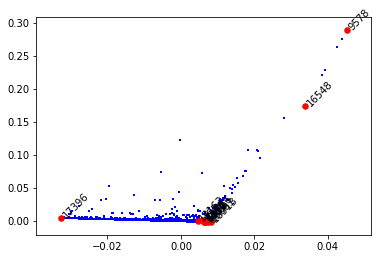

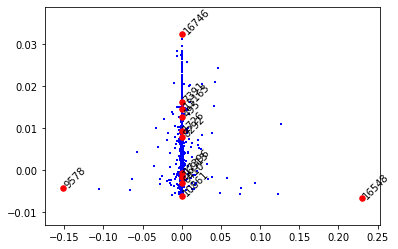

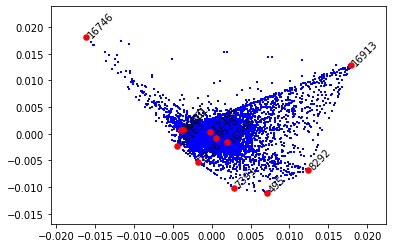

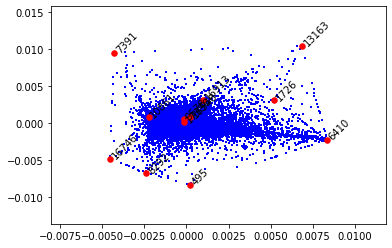

In [23]:
print("F[anchor_words,:]")
print(F[S0,:].round(6))
for i in range(F.shape[1]):
    n_anchor = find_anchor_word_k2(F, i).sum()
    print(f"topic {i}: {n_anchor} anchor words")

Cbar = pca_proj(Cbar)
vis_extremal_pca(Cbar, S0, which_dim = [0, 1], annotate=True,fontsize=10)
vis_extremal_pca(Cbar, S0, which_dim = [2, 3], annotate=True,fontsize=10)
vis_extremal_pca(Cbar, S0, which_dim = [4, 5], annotate=True,fontsize=10)
vis_extremal_pca(Cbar, S0, which_dim = [6, 7], annotate=True,fontsize=10)

### look at where are the real anchor words

In [24]:
print(F[9578,:].round(3)) ## total counts 990
print(F[17396,:].round(3)) ## total counts 289
print(F[16548,:].round(3)) ## total counts 30
print(F[16746,:].round(3)) ## total counts 7
print(F[16913,:].round(4)) ## total counts 20
print(F[13163,:].round(7)) ## total counts 20

[0.    0.    0.    0.    0.    0.249 0.    0.    0.    0.    0.    0.   ]
[0.    0.    0.001 0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
[0.    0.387 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
[0.    0.    0.    0.001 0.    0.    0.    0.    0.    0.    0.    0.   ]
[0.0002 0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.    ]
[0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 3.e-06 0.e+00
 0.e+00 0.e+00]


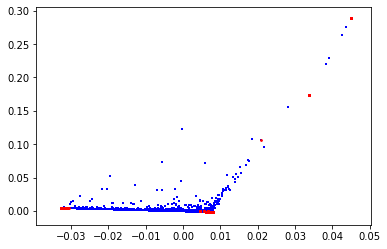

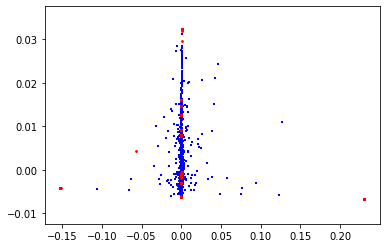

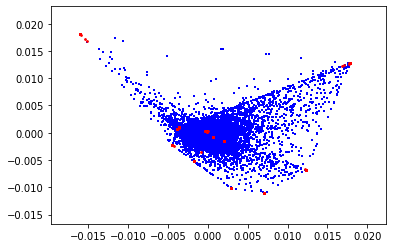

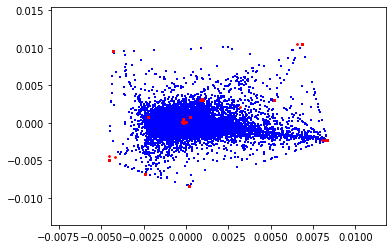

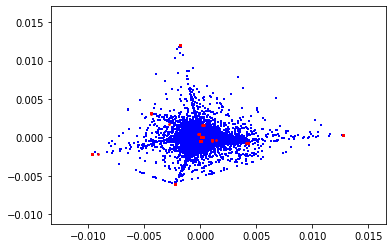

In [25]:
all_anchor_word = []
for i in range(k):
    ind = np.where(find_anchor_word_k2(F, i) == True)[0].tolist()
    all_anchor_word += ind
    
vis_extremal_pca(Cbar, all_anchor_word, which_dim = [0, 1], annotate=False,fontsize=10, s = 3)
vis_extremal_pca(Cbar, all_anchor_word, which_dim = [2, 3], annotate=False,fontsize=10, s= 3)
vis_extremal_pca(Cbar, all_anchor_word, which_dim = [4, 5], annotate=False,fontsize=10, s = 3)
vis_extremal_pca(Cbar, all_anchor_word, which_dim = [6, 7], annotate=False,fontsize=10, s = 3)
vis_extremal_pca(Cbar, all_anchor_word, which_dim = [8, 9], annotate=False,fontsize=10, s = 3)